Hello Kagglers,

This notebook gives a brief Exploratory Data Analysis, followed by object detection using [YOLOV5](https://github.com/ultralytics/yolov5) and lastly creating [TFRecords](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset).

Object detection is applied to classify the image as cat or dog and to find the contours of the pets inside the image. This could be used for cropping or to extract features. The TFRecords function for fast and easy data processing, especially when using TPU's thousands of images per second can be read.

**V2 Updates**

* Added Test Time Augmentations during YOLOV5 inference for better performance. Reduced the amount of images where no pet could be detected from 50 -> 26.

* Added pet ratio feature. This denotes the percentage in pixels of an image containing a pet.

**V3 Updates**

* Added duplicate removal based on the amazing [post](https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/278497) and [notebook](https://www.kaggle.com/schulta/petfinder-identify-duplicates-and-share-findings) from [schuta](https://www.kaggle.com/schulta)

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from multiprocessing import cpu_count
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from scipy.stats import pearsonr
from PIL import Image

import glob
import sys
import cv2
import imageio
import joblib
import math
import warnings
import os
import torch
import imagehash

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D,AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

# Read Train Test

In [15]:
train_df = pd.read_csv('/kaggle/input/590-yolo/yolotrain.csv')

In [16]:
train_df['label'].head(5)

0    dog
1    cat
2    dog
3    dog
4    dog
Name: label, dtype: object

In [17]:
train_df.drop(train_df[train_df.label == 'unknown'].index, inplace=True)

In [18]:
#len(train_df.loc[train_df['label'] == 'dog'])

In [19]:
################## Regression ###################

In [20]:
# cat = 1, dog = 0
train_df['label'] = (train_df['label'] == 'dog').astype(int)

In [21]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
train_df['filename'] = train_df['Id']+'.jpg'
#train_df.drop('img_path', axis=1, inplace=True)
train_df.drop('Id', axis=1, inplace=True)
train_df.drop('file_path', axis=1, inplace=True)
train_df.drop('coords', axis=1, inplace=True)
train_df.drop('x_min', axis=1, inplace=True)
train_df.drop('x_max', axis=1, inplace=True)
train_df.drop('y_min', axis=1, inplace=True)
train_df.drop('y_max', axis=1, inplace=True)

In [23]:
#train_df.columns
len(train_df)

9884

In [24]:
cat_df = train_df.loc[train_df['label'] == 1]
dog_df = train_df.loc[train_df['label'] == 0]
cat_df.drop('label', axis=1, inplace=True)
dog_df.drop('label', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
#######################################################################
################################ DOG ##################################

In [26]:
gen_kwargs = dict(
    dataframe=dog_df,
    directory=Path('/kaggle/input/petfinder-pawpularity-score/train'), 
    x_col='filename',
    y_col='Pawpularity',
    batch_size=32,
    seed=619,
    shuffle=True,
    class_mode='raw',
    target_size=(224, 224)
)
datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
train_generator_dog =  datagen.flow_from_dataframe(**gen_kwargs, subset="training")
valid_generator_dog =  datagen.flow_from_dataframe(**gen_kwargs, subset="validation")

Found 4233 validated image filenames.
Found 1058 validated image filenames.


In [28]:
inputs = keras.Input(shape=(224, 224, 3))

X = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
X = AveragePooling2D(pool_size=(2, 2))(X)

X = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(X)
X = AveragePooling2D(pool_size=(2, 2))(X)

X = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(X)
X = AveragePooling2D(pool_size=(2, 2))(X)

X = Flatten()(X)

X = Dense(512, activation='relu')(X)
X = Dropout(0.3)(X)

X = Dense(128, activation='relu')(X)

X = Dense(64, activation='relu')(X)

X = Dense(16, activation='relu')(X)

X = Dense(4, activation='relu')(X)

outputs = Dense(1)(X)

model = keras.Model(inputs=inputs, outputs=outputs)

2022-12-04 02:30:35.956544: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-04 02:30:35.956878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 02:30:35.957727: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-12-04 02:30:35.957926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 02:30:35.958911: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:00:05.0 name: Tes

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      1792      
_________________________________________________________________
average_pooling2d (AveragePo (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
average_pooling2d_2 (Average (None, 3, 3, 256)         0     

In [30]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    #optimizer="rmsprop",
    #loss=MeanSquaredError(),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

In [31]:
history = model.fit(
    train_generator_dog,
    validation_data=valid_generator_dog,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)]
)

2022-12-04 02:30:52.218719: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-04 02:30:52.219662: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000170000 Hz


Epoch 1/10


2022-12-04 02:30:52.775411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-04 02:30:53.513993: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-12-04 02:30:53.522985: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


133/133 [==============================] - 70s 502ms/step - loss: 587.2540 - root_mean_squared_error: 23.9135 - val_loss: 333.4494 - val_root_mean_squared_error: 18.2606
Epoch 2/10
133/133 [==============================] - 67s 503ms/step - loss: 324.6010 - root_mean_squared_error: 18.0152 - val_loss: 314.4391 - val_root_mean_squared_error: 17.7324
Epoch 3/10
133/133 [==============================] - 68s 510ms/step - loss: 310.5775 - root_mean_squared_error: 17.6174 - val_loss: 366.4778 - val_root_mean_squared_error: 19.1436
Epoch 4/10
133/133 [==============================] - 67s 502ms/step - loss: 336.9702 - root_mean_squared_error: 18.3483 - val_loss: 312.8898 - val_root_mean_squared_error: 17.6887
Epoch 5/10
133/133 [==============================] - 66s 498ms/step - loss: 339.9679 - root_mean_squared_error: 18.4329 - val_loss: 310.5008 - val_root_mean_squared_error: 17.6210
Epoch 6/10
133/133 [==============================] - 66s 498ms/step - loss: 307.8103 - root_mean_squared_

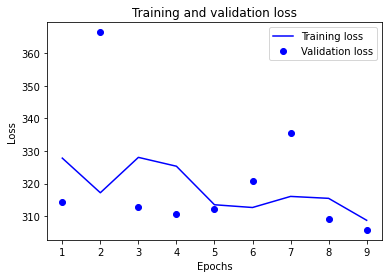

In [34]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plt.plot(range(1, len(loss_values)), loss_values[1:], 'b', label='Training loss')
plt.plot(range(1, len(loss_values)), val_loss_values[1:], 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
from skimage.transform import resize

test_df = pd.read_csv("/kaggle/input/590-yolo/yolov5.csv")
test_df = test_df[test_df['true_label']== 0]
test = test_df['file_path'].tolist()
print(test)

all_image=[]
for i in test:
    im_array=cv2.imread(i)
    im_array=resize(im_array,(224, 224),anti_aliasing=True)
    all_image.append(im_array)

X_test=np.array(all_image).reshape(-1,224,224,3)
del all_image

y_predict=model.predict(X_test)
y_predict=y_predict.reshape(-1,)

['/kaggle/input/own-tests/IMG_0969.JPG', '/kaggle/input/own-tests/IMG_0968.JPG', '/kaggle/input/own-tests/IMG_0978.JPG', '/kaggle/input/own-tests/WechatIMG829.JPG', '/kaggle/input/own-tests/pexels-anna-shvets-4587992.JPG', '/kaggle/input/own-tests/IMG_7930.JPG', '/kaggle/input/own-tests/WechatIMG830.JPG', '/kaggle/input/own-tests/IMG_0977.JPG', '/kaggle/input/own-tests/IMG_9365.JPG', '/kaggle/input/own-tests/IMG_0967.JPG', '/kaggle/input/own-tests/IMG_0971.JPG', '/kaggle/input/own-tests/WechatIMG821.JPG', '/kaggle/input/own-tests/IMG_8451.JPG', '/kaggle/input/own-tests/IMG_0970.JPG']


In [37]:
y_predict

array([32.267555, 34.061592, 34.529   , 32.479763, 38.75024 , 34.88505 ,
       31.667797, 32.80217 , 34.019054, 33.995087, 32.145786, 33.869736,
       34.821846, 33.468952], dtype=float32)

In [38]:
result = pd.DataFrame()
result['filename'] = test_df['Id']
result['Pawpularity'] = y_predict
result

,filename,Pawpularity
0,IMG_0969.JPG,32.267555
3,IMG_0968.JPG,34.061592
8,IMG_0978.JPG,34.528999
10,WechatIMG829.JPG,32.479763
11,pexels-anna-shvets-4587992.JPG,38.750240
12,IMG_7930.JPG,34.885052
14,WechatIMG830.JPG,31.667797
18,IMG_0977.JPG,32.802170
19,IMG_9365.JPG,34.019054
24,IMG_0967.JPG,33.995087
